<a href="https://www.kaggle.com/code/dhrubachakraborty/bengali-sentiment-analysis?scriptVersionId=120025074" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengali-review-dataset/Bengali Review Dataset.csv
/kaggle/input/bengali-stopwords/metadata/._SUCCESS.crc
/kaggle/input/bengali-stopwords/metadata/part-00000
/kaggle/input/bengali-stopwords/metadata/.part-00000.crc
/kaggle/input/bengali-stopwords/metadata/_SUCCESS


## Importing necessary Modules

In [4]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D
# from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

## Importing Dataset

In [5]:
reviews = pd.read_csv("/kaggle/input/bengali-review-dataset/Bengali Review Dataset.csv")

reviews.shape

(11807, 2)

In [6]:
reviews.head()

,Reviews,Sentiment
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,"""এত মোটা বাশ নিতে পারছি না বাবা """,negative
2,নাটক আসলেই অসাধারণ,positive
3,ফালতু একটা নাটক,negative
4,ধুমপান সাস্থর জন্য ক্ষতিকর।,negative


## Plotting Data

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

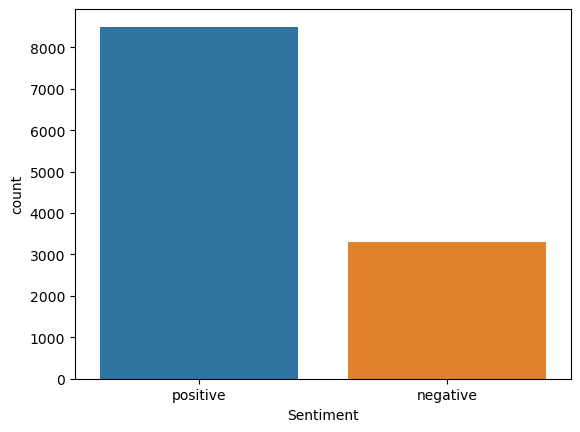

In [7]:
import seaborn as sns
sns.countplot(x = 'Sentiment', data = reviews)

## Trying to remove stopwords

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash
import sparknlp

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [ ]:

nlp_pipeline = Pipeline(stages=[document_assembler, tokenizer, stop_words])
light_pipeline = LightPipeline(nlp_pipeline.fit(spark.createDataFrame([['']]).toDF("text")))
results = light_pipeline.fullAnnotate("উত্তরের রাজা হওয়া ছাড়াও জন স্নো একজন ইংরেজ চিকিত্সক এবং অবেদন এবং মেডিকেল হাইজিনের বিকাশের এক নেতা")

In [ ]:
stop_words = StopWordsCleaner.pretrained("stopwords_bn", "bn") \
        .setInputCols(["token"]) \
        .setOutputCol("cleanTokens")
test = "উত্তরের রাজা হওয়া ছাড়াও জন স্নো একজন ইংরেজ চিকিত্সক এবং অবেদন এবং মেডিকেল হাইজিনের বিকাশের এক নেতা"


## Preprocessing

In [8]:
X = reviews['Reviews'].to_numpy()

In [9]:
X

array([' অসাধারণ নিশো বস্ আর অমি ভাইকেও।',
       ' "এত মোটা বাশ নিতে পারছি না বাবা "', ' নাটক আসলেই অসাধারণ', ...,
       ' ভাই আপনাদের এত স্পন্সর দরকার তাহলে Youtube নাটক দিছেন কেন ? নাটক ভালো ছিল But দেখে শান্তি পাইলাম না',
       'এগুলো কি নাটক না কি', ' অনেক বেশি ভালো লাগল'], dtype=object)

In [10]:
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, reviews['Sentiment'])))

In [11]:
y

array([1, 0, 1, ..., 1, 0, 1])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.10, random_state = 42)

In [59]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [60]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [61]:
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

### Model Building and Training

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='sigmoid'),
    Dropout(0.2),
#     tf.keras.layers.Dense(32, activation = 'sigmoid'),
#     Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [73]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 6)                 102       
                                                                 
 dropout_5 (Dropout)         (None, 6)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
________________________________________________

In [75]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)

In [76]:
num_epochs = 100
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/100
333/333 [==============================] - 2s 4ms/step - loss: 0.6066 - accuracy: 0.7167 - val_loss: 0.6083 - val_accuracy: 0.7011
Epoch 2/100
333/333 [==============================] - 1s 4ms/step - loss: 0.5922 - accuracy: 0.7219 - val_loss: 0.6046 - val_accuracy: 0.7011
Epoch 3/100
333/333 [==============================] - 2s 5ms/step - loss: 0.5846 - accuracy: 0.7220 - val_loss: 0.5930 - val_accuracy: 0.7011
Epoch 4/100
333/333 [==============================] - 1s 4ms/step - loss: 0.5646 - accuracy: 0.7221 - val_loss: 0.5608 - val_accuracy: 0.7011
Epoch 5/100
333/333 [==============================] - 1s 4ms/step - loss: 0.5169 - accuracy: 0.7251 - val_loss: 0.4992 - val_accuracy: 0.7028
Epoch 6/100
333/333 [==============================] - 1s 4ms/step - loss: 0.4416 - accuracy: 0.7648 - val_loss: 0.4236 - val_accuracy: 0.7333
Epoch 7/100
333/333 [==============================] - 1s 4ms/step - loss: 0.3715 - accuracy: 0.8388 - val_loss: 0.3552 - val_accuracy: 0.8501

## Plotting Accuracy, Loss, Val_Accuracy, Val_Loss

<Figure size 640x480 with 0 Axes>

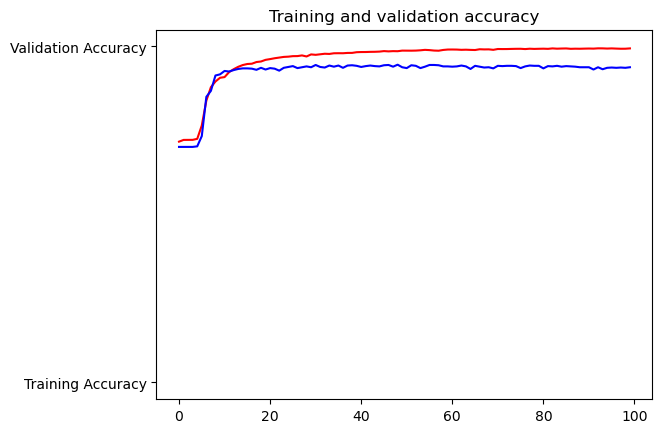

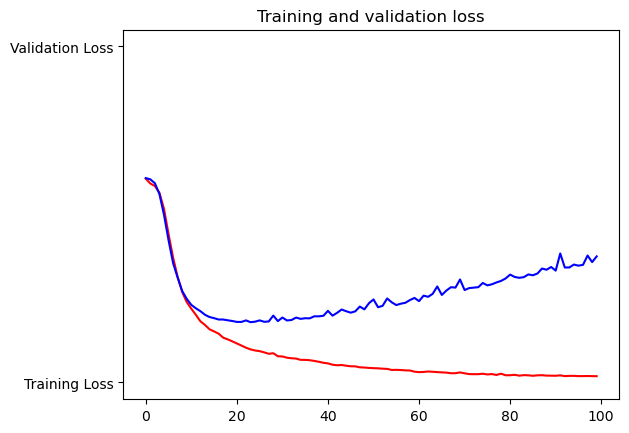

<Figure size 640x480 with 0 Axes>

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

## Creating a custom dataset and testing out model prediction

In [78]:
test = np.array(['অসাধারণ অমি ভাই', 'অনেক বাশ লাগল', 'শান্তি পাইলাম না', 'আপনি একটা বাজে লোক'])
print(test)
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
test = tokenizer.texts_to_sequences(test)
test = pad_sequences(test, maxlen=max_length)
print(test)

['অসাধারণ অমি ভাই' 'অনেক বাশ লাগল' 'শান্তি পাইলাম না' 'আপনি একটা বাজে লোক']
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4 237   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0  

In [79]:
predicted = model.predict(test)

1/1 [==============================] - 0s 58ms/step


Here the values close to 1 are positive and close to 0 are negative.
So, the model is predicting the test data very well.

In [80]:
print(predicted)

[[1.000000e+00]
 [9.884316e-01]
 [3.689654e-01]
 [4.421803e-04]]


**Our Threshold here is 0.7241**
> Total reviews = 11807

> Total positive = 8500

> Total negative = 3307

> Percentage of positive = (8500/11807)*100% = 72.41%

In [91]:
for i in predicted:
    if(i<=0.7241):
        print('Negative -','Confidence: ',round(float(i*100), 2),'%')
    else:
        print('Positive -','Confidence: ',round(float(i*100), 2),'%')

Positive - Confidence:  100.0 %
Positive - Confidence:  98.84 %
Negative - Confidence:  36.9 %
Negative - Confidence:  0.04 %
